In [2]:
from pre_processing import Pre_Process
from LDA import LDA,GensimLDA
import pyLDAvis.gensim_models

In [3]:
QA=Pre_Process('../business_text_mining/crawl_result/wineQ&A_text.json').clean_data()

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
D=Pre_Process().Check_date(QA)
print('VAR',D.var())
import chart_studio.plotly.plotly as py
import cufflinks as cf
cf.go_offline(connected=True)
D.iplot(kind='bar',colors='Red')

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


VAR 45.29108991422661


컨텐츠의 최대 길이 : 2011
컨텐츠의 평균 길이 : 162.82191590086327


/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



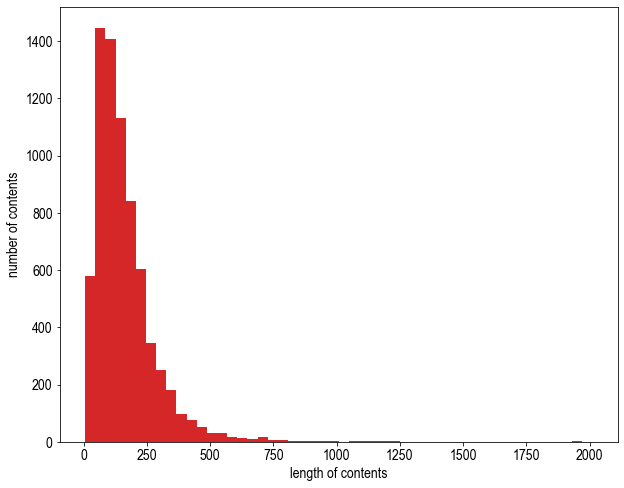

In [5]:
Pre_Process().show_contents_length(QA)

In [6]:
QA=Pre_Process().Get_unique_nouns(QA)

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



training was done. used memory 0.410 Gbry 0.275 Gb
all cohesion probabilities was computed. # words = 59465
all branching entropies was computed # words = 39925
all accessor variety was computed # words = 39925


100%|██████████| 7182/7182 [00:04<00:00, 1623.71it/s]


/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,0,1
90,없다,1378
461,싸다,1207
134,가격,1106
93,괜찮다,1042
239,추천,1026
...,...,...
438,공기,29
2350,트레이더스,29
3206,교환,29
1873,제일,29


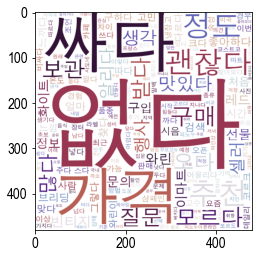

In [7]:
Pre_Process().Get_Nouns_Freq(QA,600,True)

In [8]:
import re
def get_text_with_word(word):
    l=re.findall('(ㅠㅠ)',word)
    L=re.findall('(ㅜㅜ)',word)
    i=re.findall('(\?\?)',word)
    return len(l)+len(i)+len(L)

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<>:5: DeprecationWarning:

invalid escape sequence \?

<>:5: DeprecationWarning:

invalid escape sequence \?

<ipython-input-8-d940f31ae3a4>:5: DeprecationWarning:

invalid escape sequence \?



In [9]:
QA['pain']=QA.contents.apply(lambda x :'pain' if get_text_with_word(x) != 0 else '')
PAIN=QA[QA.pain!='']

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
PAIN=QA[QA.pain!='']

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# LDA

In [11]:
Topic=LDA(QA,3)

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Topic 0
가격,받다,없다,괜찮다,선물,추천,정보,빈티지,모르다,검색,찾다,싸다,구하다,알리다,크다,스다,오다,문의,차이,찾아보다
Topic 1
코르크,느끼다,느낌,따다,처음,맞다,좋아하다,이상,오다,없다,그렇다,코스트코,맛있다,와린,품종,이렇다,상태,종류,정도,레드
Topic 2
행사,보관,싸다,셀러,이마트,정도,어울리다,시음,구매,가능,사람,괜찮다,얼마,장터,가격,이번,냉장고,없다,온도,구입


In [12]:
def drop_certain_words(corpus, sparse_matrix, drop_words):
    drop_words_index = [np.where(corpus == word)[0][0] for word in drop_words]
    to_keep = sorted(set(range(sparse_matrix.shape[1])) - set(drop_words_index))
    corpus = corpus[to_keep]
    sparse_matrix = sparse_matrix[:, to_keep]
    return corpus, sparse_matrix

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [13]:
def closer_look(df, topic_num, content, limit=40):
    each_topic_df = df[df['topic label'] == topic_num]
    print(each_topic_df[['topic prob', '제목', '본문', '댓글']].sort_values(by='topic prob', ascending=False)[content][:limit])

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# gensim

In [14]:
vis=GensimLDA(QA,10)
pyLDAvis.display(vis)

/Users/sujin/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

